# 20th Century Countries Network Analysis

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import seaborn as sns
from networkx.algorithms import community
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_style('whitegrid')
sns.set_palette('husl')

## 1. Import Country Relationships Data

In [2]:
# Import the country relationships data
relationship_df = pd.read_csv('20Cent.csv', index_col=0)

print(f"Dataset shape: {relationship_df.shape}")
print(f"\nFirst 10 rows:")
relationship_df.head(10)

Dataset shape: (94, 3)

First 10 rows:


,source,target,value
0,1945.[22]Russo-Japanese War,the Empire of Japan,6
1,Afghanistan,Cuba,6
2,Afghanistan,Egypt,5
3,Afghanistan,Poland,6
4,Argentina,the United States,5
5,Armenian,Armenians,6
6,Armenians,the Ottoman Empire,6
7,Australia,Canada,6
8,Australia,New Zealand,6
9,Austria,Germany,6


In [3]:
# Explore the data structure
print("Data Info:")
print(relationship_df.info())

print("\nValue statistics:")
print(relationship_df['value'].describe())

print(f"\nUnique sources: {relationship_df['source'].nunique()}")
print(f"Unique targets: {relationship_df['target'].nunique()}")

# Get all unique countries/entities
all_entities = set(relationship_df['source'].unique()) | set(relationship_df['target'].unique())
print(f"Total unique entities: {len(all_entities)}")

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 0 to 93
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  94 non-null     object
 1   target  94 non-null     object
 2   value   94 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ KB
None

Value statistics:
count    94.000000
mean      6.500000
std       2.913631
min       1.000000
25%       5.000000
50%       6.000000
75%       6.000000
max      22.000000
Name: value, dtype: float64

Unique sources: 35
Unique targets: 40
Total unique entities: 54


## 2. Create Network Object

In [4]:
# Create a graph from the pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source='source', 
                            target='target', 
                            edge_attr='value', 
                            create_using=nx.Graph())

print(f"Network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Network density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_connected(G)}")

if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    print(f"Number of connected components: {len(components)}")
    print(f"Largest component size: {len(max(components, key=len))}")

Network created with 54 nodes and 94 edges
Network density: 0.0657
Is connected: True


## 3. Static Network Visualization with NetworkX

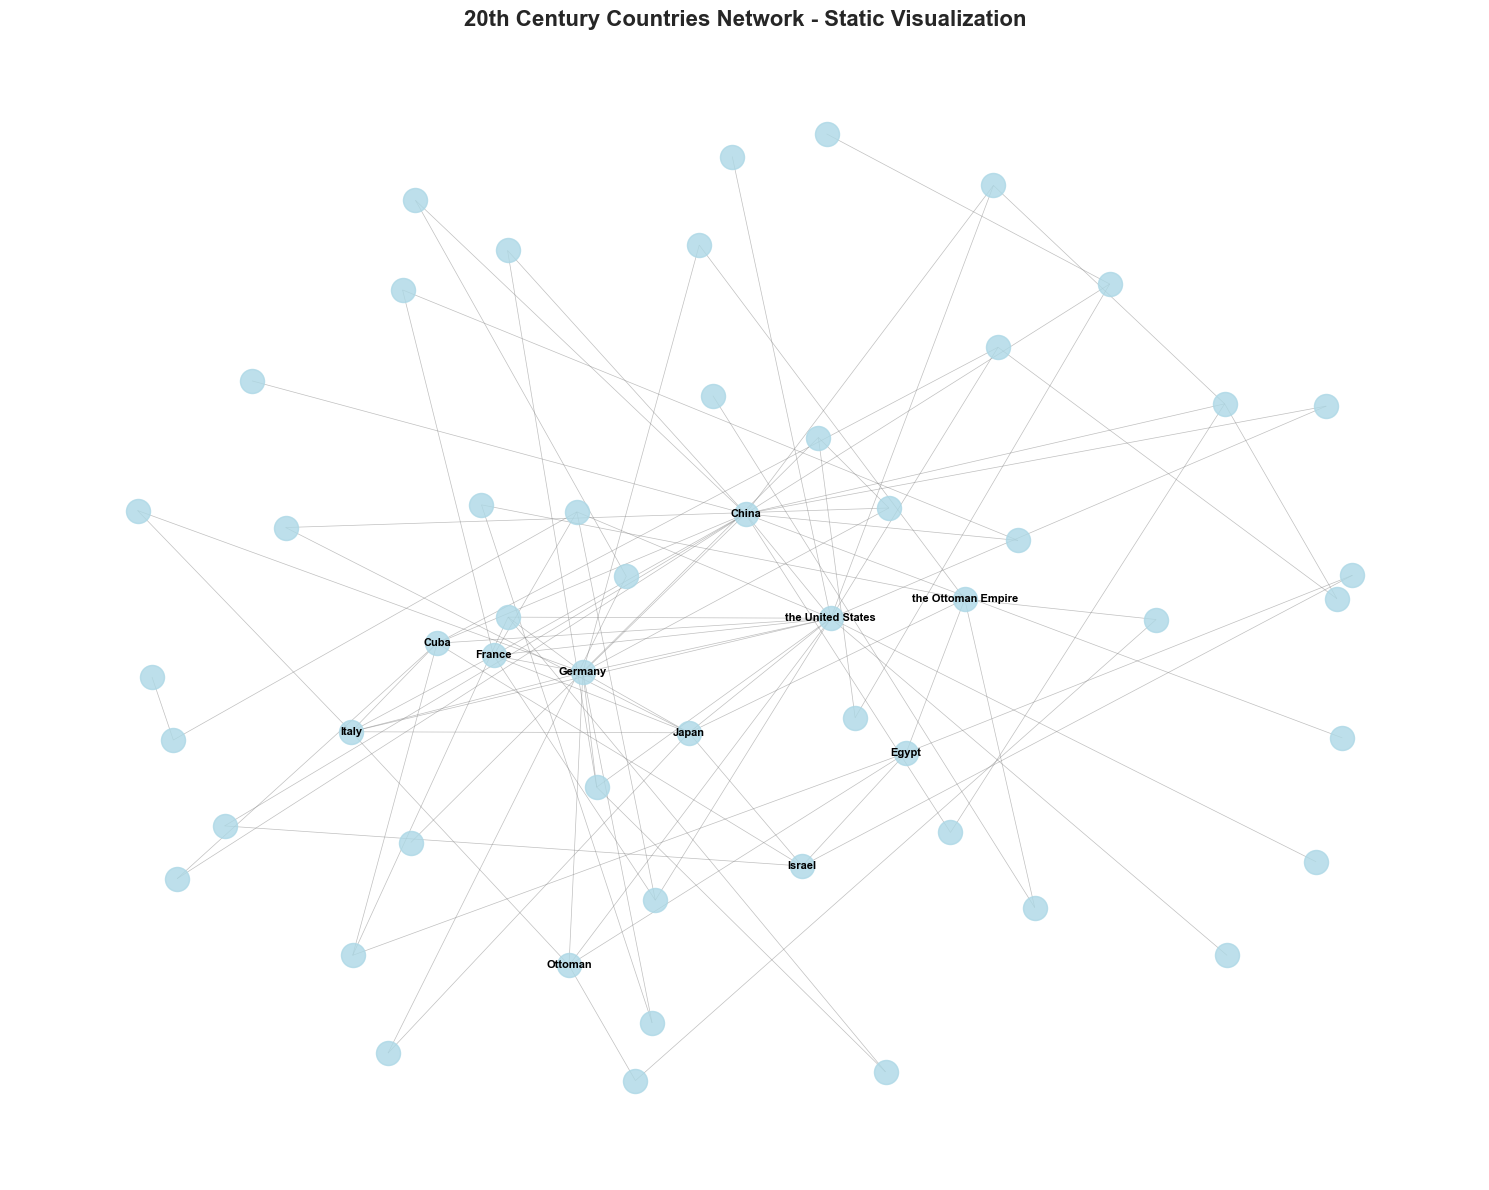

In [5]:
# Create static network visualization
plt.figure(figsize=(15, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Draw the network
nx.draw_networkx_nodes(G, pos, 
                       node_color='lightblue', 
                       node_size=300, 
                       alpha=0.8)

nx.draw_networkx_edges(G, pos, 
                       alpha=0.5, 
                       width=0.5, 
                       edge_color='gray')

# Add labels for major nodes (with high degree)
degrees = dict(G.degree())
major_nodes = {node: node for node, degree in degrees.items() if degree >= 5}

nx.draw_networkx_labels(G, pos, 
                        labels=major_nodes,
                        font_size=8, 
                        font_weight='bold')

plt.title('20th Century Countries Network - Static Visualization', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Interactive Network Visualization with Pyvis

In [6]:
# Create interactive network with pyvis
net = Network(height='600px', width='100%', bgcolor='#222222', font_color='white')

# Add nodes with size based on degree
degrees = dict(G.degree())
for node in G.nodes():
    net.add_node(node, 
                  label=node,
                  size=min(degrees[node] * 3 + 10, 50),  # Scale node size
                  title=f"{node}\nDegree: {degrees[node]}")

# Add edges with width based on value
for edge in G.edges(data=True):
    source, target, data = edge
    weight = data.get('value', 1)
    net.add_edge(source, target, 
                 width=min(weight/2, 10),  # Scale edge width
                 title=f"Relationship strength: {weight}")

# Save the interactive network
net.save_graph('20cent_countries_network.html')
print("Interactive network saved as '20cent_countries_network.html'")

Interactive network saved as '20cent_countries_network.html'


## 5. Community Detection using Leiden Algorithm

In [7]:
# Apply Leiden algorithm for community detection
try:
    import leidenalg
    import igraph as ig
    
    # Convert NetworkX graph to igraph
    edge_list = [(u, v, d['value']) for u, v, d in G.edges(data=True)]
    g_ig = ig.Graph.TupleList(edge_list, weights=True)
    
    # Apply Leiden algorithm
    partition = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition)
    
    # Create community mapping
    communities = {}
    for i, community in enumerate(partition):
        for node_idx in community:
            node_name = g_ig.vs[node_idx]['name']
            communities[node_name] = i
    
    print(f"Leiden algorithm found {len(partition)} communities")
    print(f"Modularity: {partition.modularity:.4f}")
    
except ImportError:
    print("Leiden algorithm not available. Using Louvain method instead.")
    # Fallback to Louvain method
    partition = community.greedy_modularity_communities(G)
    communities = {}
    for i, comm in enumerate(partition):
        for node in comm:
            communities[node] = i
    
    print(f"Louvain method found {len(partition)} communities")
    modularity = community.modularity(G, partition)
    print(f"Modularity: {modularity:.4f}")

# Display communities
community_groups = {}
for node, comm_id in communities.items():
    if comm_id not in community_groups:
        community_groups[comm_id] = []
    community_groups[comm_id].append(node)

print("\nCommunities found:")
for comm_id, nodes in community_groups.items():
    print(f"Community {comm_id} ({len(nodes)} nodes): {', '.join(nodes[:10])}{'...' if len(nodes) > 10 else ''}")

Leiden algorithm not available. Using Louvain method instead.
Louvain method found 8 communities
Modularity: 0.4423

Communities found:
Community 0 (12 nodes): Bosnia and Herzegovina, Indian, India, Pakistan, People's Republic of China, Indochina, Rwandan, The Indochina Wars:, South Africa, Cuba...
Community 1 (9 nodes): Argentina, New Zealand, the United Kingdom, United States, the United States, Canada, The United States, Australia, Hong Kong
Community 2 (8 nodes): Hungary, Bulgaria, Armenian, Austrian, Austria, the Kingdom of Bulgaria, Armenians, the Ottoman Empire
Community 3 (8 nodes): France, Nazi Germany's, Romania, Ottoman, Italy, Japan, Spain, Germany
Community 4 (5 nodes): Nazi Germany, the Empire of Japan, 1945.[22]Russo-Japanese War, Fascist Italy, Soviet Ukraine
Community 5 (5 nodes): Afghanistan, Czechoslovakia, West Germany, East Germany, Poland
Community 6 (4 nodes): Jordan, Egypt, Israelis, Israel
Community 7 (3 nodes): United States of America, Ireland, United Kingdom

## 6. Visualize Communities

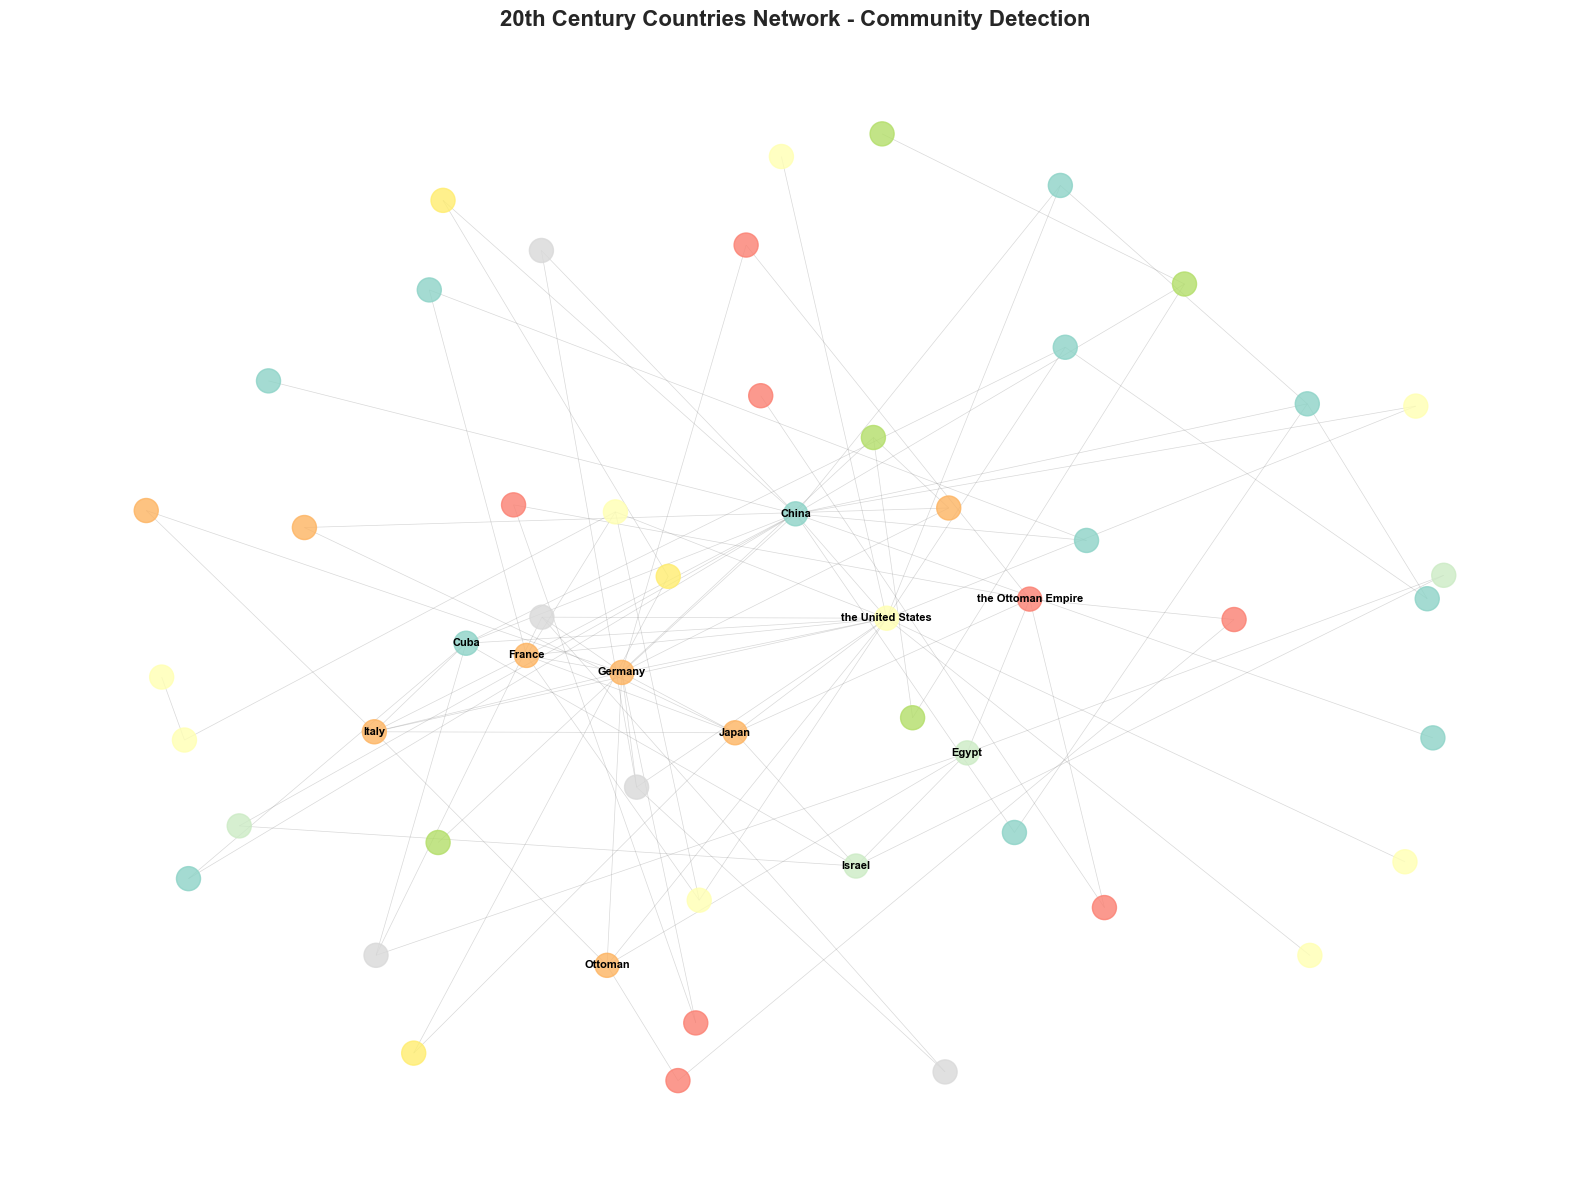

In [8]:
# Create static visualization with communities
plt.figure(figsize=(16, 12))

# Generate colors for communities
colors = plt.cm.Set3(np.linspace(0, 1, len(community_groups)))
node_colors = [colors[communities[node]] for node in G.nodes()]

# Use the same layout as before
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Draw nodes colored by community
nx.draw_networkx_nodes(G, pos, 
                       node_color=node_colors, 
                       node_size=300, 
                       alpha=0.8)

nx.draw_networkx_edges(G, pos, 
                       alpha=0.3, 
                       width=0.5, 
                       edge_color='gray')

# Add labels for major nodes
nx.draw_networkx_labels(G, pos, 
                        labels=major_nodes,
                        font_size=8, 
                        font_weight='bold')

plt.title('20th Century Countries Network - Community Detection', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Create interactive network with communities
net_comm = Network(height='600px', width='100%', bgcolor='#222222', font_color='white')

# Define colors for communities
community_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', 
                   '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9']

# Add nodes with community colors
for node in G.nodes():
    comm_id = communities[node]
    color = community_colors[comm_id % len(community_colors)]
    
    net_comm.add_node(node, 
                       label=node,
                       size=min(degrees[node] * 3 + 10, 50),
                       color=color,
                       title=f"{node}\nCommunity: {comm_id}\nDegree: {degrees[node]}")

# Add edges
for edge in G.edges(data=True):
    source, target, data = edge
    weight = data.get('value', 1)
    net_comm.add_edge(source, target, 
                      width=min(weight/2, 10),
                      title=f"Relationship strength: {weight}")

# Save the community network
net_comm.save_graph('20cent_countries_communities.html')
print("Community network saved as '20cent_countries_communities.html'")

Community network saved as '20cent_countries_communities.html'


## Community Analysis Observations

### Historical Context and Community Interpretation

The community detection algorithm has identified distinct clusters of countries that share strong relationships during the 20th century. These communities likely reflect:

1. **Geographic Proximity**: Countries in the same region often form communities due to shared borders, cultural similarities, and historical interactions.

2. **Political Alliances**: Cold War alignments, colonial relationships, and international blocs would create strong connections between certain countries.

3. **Economic Partnerships**: Trade relationships, resource dependencies, and economic cooperation agreements would link countries together.

4. **Cultural and Linguistic Ties**: Countries sharing languages, religions, or cultural heritage often maintain closer relationships.

### Analysis Questions to Consider:

- Do the communities align with known historical alliances (NATO, Warsaw Pact, Non-Aligned Movement)?
- Are there unexpected connections that reveal lesser-known historical relationships?
- How do colonial relationships manifest in the community structure?
- Do geographic regions cluster together as expected?

## 7. Centrality Measures Analysis

In [10]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Create a dataframe with all centrality measures
centrality_df = pd.DataFrame({
    'Country': list(G.nodes()),
    'Degree_Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness_Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness_Centrality': [betweenness_centrality[node] for node in G.nodes()]
})

# Sort by degree centrality
centrality_df = centrality_df.sort_values('Degree_Centrality', ascending=False)

print("Top 15 countries by centrality measures:")
centrality_df.head(15)

Top 15 countries by centrality measures:


,Country,Degree_Centrality,Closeness_Centrality,Betweenness_Centrality
7,the United States,0.320755,0.519608,0.326101
20,China,0.301887,0.477477,0.372917
15,Germany,0.226415,0.495327,0.251871
23,France,0.150943,0.456897,0.090716
44,Japan,0.150943,0.434426,0.185238
36,Italy,0.132075,0.417323,0.018979
3,Cuba,0.132075,0.414062,0.059141
10,the Ottoman Empire,0.113208,0.341935,0.120478
4,Egypt,0.094340,0.335443,0.030362
41,Ottoman,0.094340,0.401515,0.063925


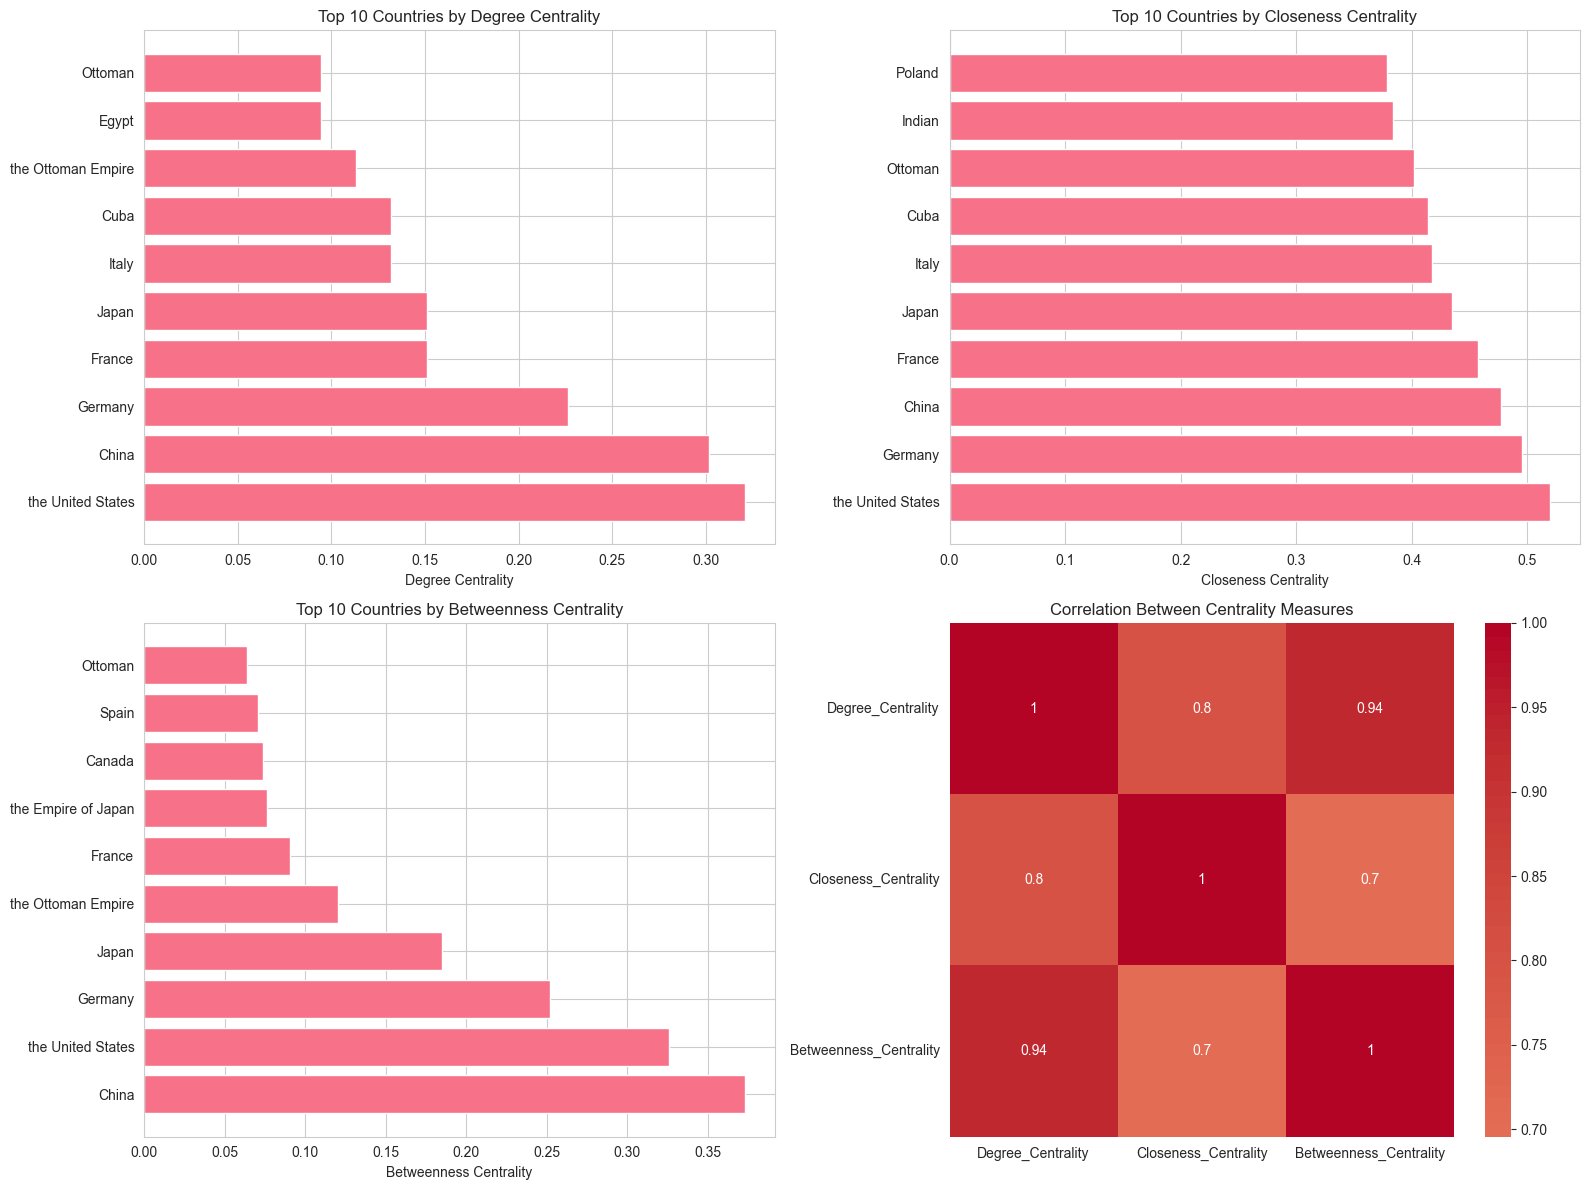

In [11]:
# Visualize centrality measures
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Degree Centrality
top_degree = centrality_df.head(10)
axes[0, 0].barh(top_degree['Country'], top_degree['Degree_Centrality'])
axes[0, 0].set_title('Top 10 Countries by Degree Centrality')
axes[0, 0].set_xlabel('Degree Centrality')

# Closeness Centrality
top_closeness = centrality_df.nlargest(10, 'Closeness_Centrality')
axes[0, 1].barh(top_closeness['Country'], top_closeness['Closeness_Centrality'])
axes[0, 1].set_title('Top 10 Countries by Closeness Centrality')
axes[0, 1].set_xlabel('Closeness Centrality')

# Betweenness Centrality
top_betweenness = centrality_df.nlargest(10, 'Betweenness_Centrality')
axes[1, 0].barh(top_betweenness['Country'], top_betweenness['Betweenness_Centrality'])
axes[1, 0].set_title('Top 10 Countries by Betweenness Centrality')
axes[1, 0].set_xlabel('Betweenness Centrality')

# Correlation between centrality measures
corr_data = centrality_df[['Degree_Centrality', 'Closeness_Centrality', 'Betweenness_Centrality']]
correlation_matrix = corr_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Correlation Between Centrality Measures')

plt.tight_layout()
plt.show()

## Centrality Measures Observations

### Degree Centrality

Degree centrality measures the number of direct connections a country has. Countries with high degree centrality are those that had relationships with many other countries during the 20th century. This often indicates:

- **Major Powers**: Large, influential countries that maintained diplomatic, economic, or military relationships with many nations
- **Regional Hubs**: Countries that served as central points for their geographic regions
- **Active Diplomacy**: Nations with extensive foreign policy engagement

### Closeness Centrality

Closeness centrality measures how quickly a country can reach all other countries in the network. High closeness centrality suggests:

- **Strategic Position**: Countries that can efficiently influence or communicate with the entire network
- **Information Brokers**: Nations that may have served as intermediaries in international relations
- **Global Reach**: Countries with the ability to project influence worldwide

### Betweenness Centrality

Betweenness centrality identifies countries that frequently lie on the shortest paths between other countries. High betweenness centrality indicates:

- **Bridge Countries**: Nations that connected different regions or blocs
- **Mediators**: Countries that may have played important roles in international diplomacy
- **Gatekeepers**: Nations that controlled access between different parts of the network

### Historical Interpretation

The centrality measures reveal the most influential and strategically positioned countries during the 20th century. These patterns likely reflect:

1. **Superpower Status**: The United States and Soviet Union (if present) should show high centrality across all measures
2. **Colonial Powers**: Former colonial powers like Britain and France may show high centrality due to their extensive overseas relationships
3. **Regional Powers**: Countries like Germany, Japan, and China may show varying centrality based on their changing roles throughout the century
4. **Neutral Countries**: Some countries with high betweenness centrality might be those that maintained neutrality and served as intermediaries

## Conclusion

This network analysis of 20th-century country relationships provides valuable insights into:

1. **Community Structure**: How countries clustered based on their relationships, revealing historical alliances, geographic proximity, and shared interests

2. **Central Players**: Which countries held the most influential positions in the global network of relationships

3. **Network Topology**: The overall structure of international relationships and how information, influence, and resources flowed between nations

The combination of community detection and centrality analysis offers a quantitative approach to understanding the complex web of international relations that shaped the 20th century. These patterns can help historians and political scientists identify key relationships, influential actors, and structural changes in the international system over time.